### Figures 2–5: Rigden et al. (2025), *Environmental Research: Water*
This notebook reproduces Figures 2–5 from the main text of Rigden et al. (2025).  
It uses GRACE-derived terrestrial water storage and precipitation data to analyze and visualize Okavango Delta hydrology.

### Import required libraries
This section loads all Python packages used for data processing, spatial analysis, statistics, and plotting.

In [1]:
# --- Standard library --------------------------------------------------------
import calendar
from pathlib import Path

# --- Core scientific stack ---------------------------------------------------
import numpy as np
import pandas as pd
import xarray as xr

# --- GIS / spatial tools -----------------------------------------------------
import geopandas as gpd
from shapely.geometry import box, mapping
from affine import Affine
import rasterio.features
from rasterio.features import rasterize
from scipy.spatial import cKDTree

# --- Plotting ----------------------------------------------------------------
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm  # colourmaps

# --- Statistics / modelling --------------------------------------------------
from scipy.stats import linregress, pearsonr, spearmanr, probplot
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import resample
from sklearn.metrics import r2_score

import pwlf  # piece-wise linear fit library

# --- Plot settings -----------------------------------------------------------
plt.rcParams.update({
    "font.size":        14,
    "axes.titlesize":   14,
    "axes.labelsize":   14,
    "xtick.labelsize":  14,
    "ytick.labelsize":  14,
    "legend.fontsize":  14,
    "figure.titlesize": 16,
})


### Load example datasets  
Open the preprocessed GRACE and CHIRPS subset files used for analysis and plotting.

In [40]:
# Load GRACE and CHIRPS precipitation datasets
ds_grace_sub = xr.open_dataset("example_data/GRACE_TWS_Angola_2002-2024.nc")
ds_precip_sub = xr.open_dataset("example_data/CHIRPS_cm_Angola_1981-2024.nc")

### Regrid CHIRPS data to GRACE resolution  
CHIRPS precipitation is spatially averaged to match the 0.5° GRACE grid, ensuring both datasets share the same spatial alignment.

In [6]:
# Initialize empty list to store averaged values
block_means = []

# Loop over each GRACE grid cell center
for lat_center in ds_grace_sub.lat.values:
    for lon_center in ds_grace_sub.lon.values:
        
        # Define bounding box: ±0.25° from center
        lat_min = lat_center - 0.25
        lat_max = lat_center + 0.25
        lon_min = lon_center - 0.25
        lon_max = lon_center + 0.25
        
        # Select CHIRPS pixels within the box and average
        block = ds_precip_sub['pr'].sel(
            lat=slice(lat_min, lat_max),
            lon=slice(lon_min, lon_max)
        )
        
        # Average over lat/lon
        block_mean = block.mean(dim=["lat", "lon"])
        
        # Store mean with corresponding coordinates
        block_means.append(
            block_mean.assign_coords(lat=lat_center, lon=lon_center)
        )

# Combine all blocks into a single DataArray on the GRACE grid
pr_interp = xr.concat(block_means, dim="z").set_index(z=["lat", "lon"]).unstack("z")

### Aggregate CHIRPS precipitation by GRACE mascon  
CHIRPS precipitation values are averaged within each GRACE mascon region to produce time series consistent with GRACE’s spatial footprint.


In [7]:
# Create a lookup table mapping each (lat, lon) to its GRACE mascon ID
mascon_ID_flat = ds_grace_sub["mascon_ID"].values.flatten()
lat_vals  = ds_grace_sub["lat"].values
lon_vals  = ds_grace_sub["lon"].values
lat_flat  = np.repeat(lat_vals, len(lon_vals))
lon_flat  = np.tile(lon_vals,  len(lat_vals))

mascon_df = pd.DataFrame({
    "lat": lat_flat,
    "lon": lon_flat,
    "mascon_ID": mascon_ID_flat
}).dropna(subset=["mascon_ID"])

# Convert interpolated CHIRPS to a DataFrame
precip_df = pr_interp.to_dataframe(name="precip").reset_index()

# Attach mascon IDs to CHIRPS pixels
precip_df = pd.merge(
    precip_df,
    mascon_df,
    on=["lat", "lon"],
    how="inner"
)

# Compute mascon-mean CHIRPS precipitation for each time step
mascon_means = (
    precip_df
    .groupby(["time", "mascon_ID"])["precip"]
    .mean()
    .reset_index()
)

# Map mascon means back to the 0.5° grid via mascon ID
precip_df = pd.merge(
    precip_df[["time", "lat", "lon", "mascon_ID"]],
    mascon_means,
    on=["time", "mascon_ID"],
    how="left"
)

# Convert the result back to an xarray Dataset on the 0.5° grid
ds_precip_mascon = precip_df.set_index(["time", "lat", "lon"]).to_xarray()


### Flatten and align datasets  
Convert GRACE and CHIRPS mascon-mean data to flat monthly DataFrames for consistent time alignment and easier merging.

In [8]:
# Flatten GRACE TWS to a tidy DataFrame
tws_mascon_df = (
    ds_grace_sub["lwe_thickness"]
    .to_dataframe(name="tws")
    .reset_index()
)

# Normalize time to monthly timestamps
tws_mascon_df["time"] = tws_mascon_df["time"].dt.to_period("M").dt.to_timestamp()

# Average any duplicate (time, lat, lon) rows
tws_mascon_df = (
    tws_mascon_df
    .groupby(["time", "lat", "lon"])["tws"]
    .mean()
    .reset_index()
)

# Flatten CHIRPS mascon-mean precipitation
precip_mascon_df = (
    ds_precip_mascon
    .to_dataframe()
    .reset_index()
)

# Match CHIRPS time formatting to GRACE
precip_mascon_df["time"] = precip_mascon_df["time"].dt.to_period("M").dt.to_timestamp()

### Load river basin boundaries  
Import HydroBASINS shapefiles for the Cubango and Cuito basins, reprojected to WGS84 for compatibility with the gridded data.


In [10]:
# Load HydroBASINS Level-04 shapefile for Africa
shapefile_path = "example_data/RiverBasins/hybas_af_lev04_v1c.shp"
gdf_basins = gpd.read_file(shapefile_path)

# Define HYBAS_IDs for Cubango and Cuito basins
basin_ids_dict = {
    "cubango": [1041477980],
    "cuito":  [1041479540],
    "both":   [1041477980, 1041479540]
}

# Select and reproject the target basins
basin_choice = "both"  # change to "cubango" or "cuito" to isolate one
selected_ids = basin_ids_dict[basin_choice]
basins = gdf_basins[gdf_basins["HYBAS_ID"].isin(selected_ids)].to_crs("EPSG:4326")

### Figure 1C–D: Monthly CHIRPS precipitation and GRACE TWS (Water Year 2004)  
Twelve-panel maps showing monthly CHIRPS precipitation (C) and GRACE terrestrial water storage anomalies (D) for September 2003–August 2004, matching the figure layout in the manuscript.

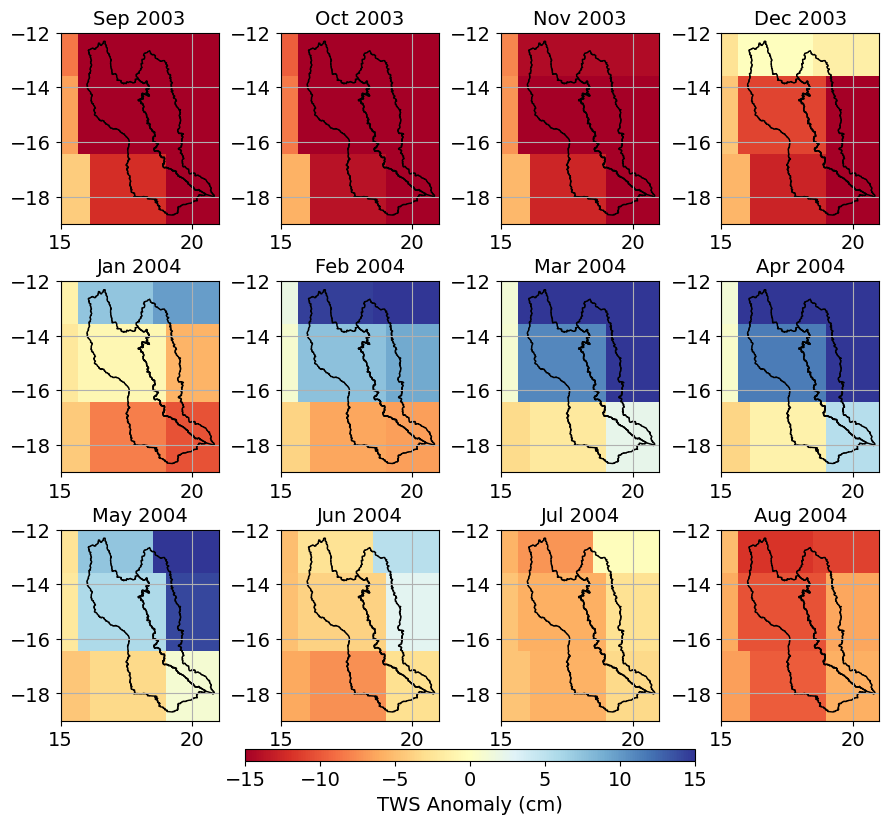

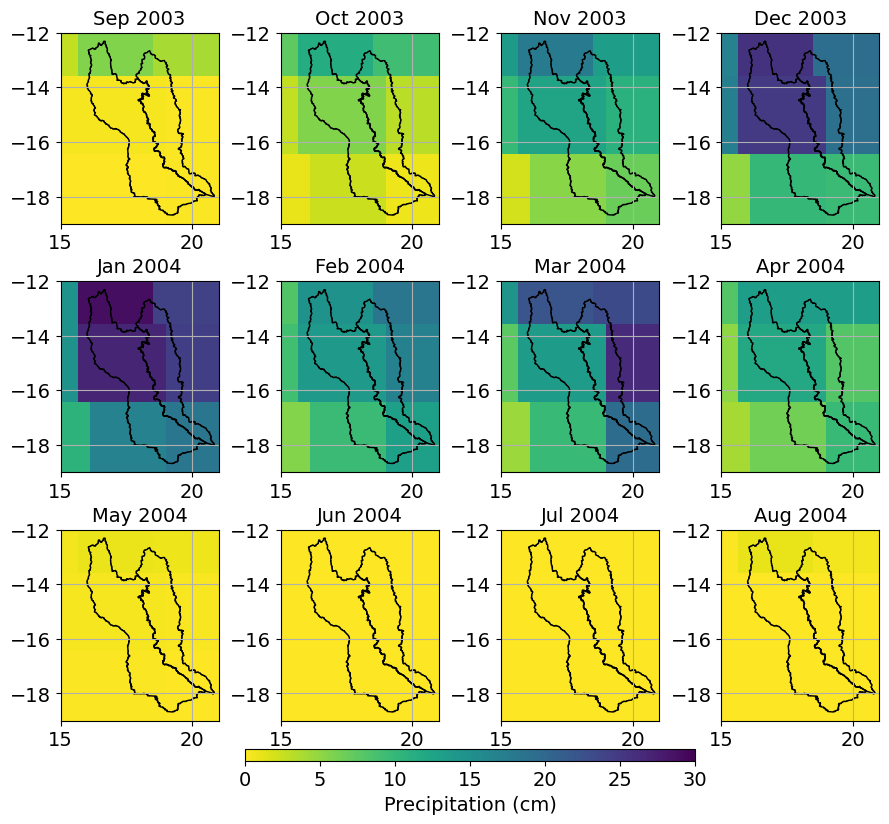

In [11]:
# Create output folder
from pathlib import Path
Path("Figures").mkdir(exist_ok=True)  # ensure output folder exists

# Colormaps and normalizers
cmap_tws    = plt.get_cmap("RdYlBu")
cmap_precip = plt.get_cmap("viridis_r")
norm_tws    = mcolors.TwoSlopeNorm(vmin=-15, vcenter=0, vmax=15)
vmin_precip, vmax_precip = 0, 30  # cm

# Water year months: Sep 2003–Aug 2004 (mid-month timestamps)
water_year = pd.date_range("2003-09-01", periods=12, freq="MS") + pd.Timedelta(days=14)

def plot_monthly_grid(df, value_col, cmap, norm_kwargs, out_fn, cbar_label):
    fig, axes = plt.subplots(3, 4, figsize=(10, 8))
    axes = axes.flatten()

    for i, (ax, date) in enumerate(zip(axes, water_year)):
        subset = df[df["time"].dt.to_period("M") == date.to_period("M")]
        if subset.empty:
            ax.axis("off")
            continue

        grid = subset.pivot_table(index="lat", columns="lon", values=value_col)
        im = ax.imshow(
            grid.values,
            cmap=cmap,
            **norm_kwargs,
            extent=[grid.columns.min(), grid.columns.max(),
                    grid.index.min(),   grid.index.max()],
            origin="lower",
            aspect="auto"
        )
        basins.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1.0)
        ax.set_title(date.strftime("%b %Y"))
        ax.set_xlim(15, 21)
        ax.set_ylim(-19, -12)
        ax.grid(True)

    # Colorbar
    cax = fig.add_axes([0.24, 0.02, 0.45, 0.015])
    cb  = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.set_label(cbar_label)

    fig.subplots_adjust(left=0.05, right=0.88, top=0.93, bottom=0.07,
                        wspace=0.3, hspace=0.3)
    if basin_choice == "both":
        fig.savefig(out_fn, dpi=300, bbox_inches="tight")
    plt.show()

# Plot GRACE TWS (Figure 2D)
plot_monthly_grid(
    tws_mascon_df, "tws", cmap_tws,
    {"norm": norm_tws},
    "Figures/Figure2D.pdf",
    "TWS Anomaly (cm)"
)

# Plot CHIRPS precipitation (Figure 2C)
plot_monthly_grid(
    precip_mascon_df, "precip", cmap_precip,
    {"vmin": vmin_precip, "vmax": vmax_precip},
    "Figures/Figure2C.pdf",
    "Precipitation (cm)"
)


### Basin-weighted monthly means
Rasterize the basin at 0.01° to estimate fractional coverage of each 0.5° GRACE cell, normalize those fractions to weights, and compute weighted monthly means of GRACE TWS and CHIRPS precipitation. The result is `df_combined_monthly` (index: monthly time; columns: `Precip`, `TWS`).


In [13]:
# Define GRACE grid and resolution
lat_vals = np.sort(tws_mascon_df["lat"].unique())
lon_vals = np.sort(tws_mascon_df["lon"].unique())
res = 0.5  # GRACE resolution

# Build a high-resolution grid for rasterization
high_res = 0.01
hi_lat = np.arange(lat_vals.min() - 1, lat_vals.max() + 1, high_res)
hi_lon = np.arange(lon_vals.min() - 1, lon_vals.max() + 1, high_res)
hi_transform = Affine.translation(hi_lon[0], hi_lat[0]) * Affine.scale(high_res, high_res)
hi_shape = (len(hi_lat), len(hi_lon))

# Rasterize the basin polygon on the high-resolution grid
basin_mask_hi = rasterize(
    [(geom, 1) for geom in basins.geometry],
    out_shape=hi_shape,
    transform=hi_transform,
    fill=0,
    dtype="float32",
    all_touched=False
)

# Compute fractional basin area for each 0.5° GRACE cell
fraction_mask = np.zeros((len(lat_vals), len(lon_vals)))
for i, lat_c in enumerate(lat_vals):
    for j, lon_c in enumerate(lon_vals):
        lat_min, lat_max = lat_c - res/2, lat_c + res/2
        lon_min, lon_max = lon_c - res/2, lon_c + res/2
        row_start = int((lat_min - hi_lat[0]) / high_res)
        row_end   = int((lat_max - hi_lat[0]) / high_res)
        col_start = int((lon_min - hi_lon[0]) / high_res)
        col_end   = int((lon_max - hi_lon[0]) / high_res)
        cell = basin_mask_hi[row_start:row_end, col_start:col_end]
        fraction_mask[i, j] = cell.sum() / cell.size

# Convert fractions to a weights table (normalized over the domain)
weights_df = pd.DataFrame({
    "lat": np.repeat(lat_vals, len(lon_vals)),
    "lon": np.tile(lon_vals, len(lat_vals)),
    "weight": fraction_mask.flatten()
})
weights_df = weights_df[weights_df["weight"] > 0]
weights_df["weight"] /= weights_df["weight"].sum()  # normalize

# Compute basin-weighted monthly TWS
tws_weighted = (
    tws_mascon_df
    .merge(weights_df, on=["lat", "lon"])
    .assign(weighted_val=lambda df: df["tws"] * df["weight"])
    .groupby("time")["weighted_val"]
    .sum()
    .reset_index(name="TWS")
)

# Compute basin-weighted monthly precipitation
precip_weighted = (
    precip_mascon_df
    .merge(weights_df, on=["lat", "lon"])
    .assign(weighted_val=lambda df: df["precip"] * df["weight"])
    .groupby("time")["weighted_val"]
    .sum()
    .reset_index(name="Precip")
)

# Merge into a single monthly time series
df_combined_monthly = (
    pd.merge(tws_weighted, precip_weighted, on="time", how="outer")
    .sort_values("time")
)
df_combined_monthly["time"] = pd.to_datetime(df_combined_monthly["time"])
df_combined_monthly = df_combined_monthly.set_index("time")[["Precip", "TWS"]]

# Optional check: inspect one year
print(df_combined_monthly[df_combined_monthly.index.year == 2012])

               Precip        TWS
time                            
2012-01-01  15.008771  31.633259
2012-02-01  17.693698  36.478270
2012-03-01  15.247276  45.916347
2012-04-01   0.950185  42.635162
2012-05-01   0.387481        NaN
2012-06-01   0.000898  26.911730
2012-07-01   0.000007  24.459469
2012-08-01   0.027855  17.741968
2012-09-01   1.368037  16.915337
2012-10-01   8.006002        NaN
2012-11-01  12.170267  13.693417
2012-12-01  17.745712  24.566574


### Figure 1A–B: Time series of GRACE TWS and CHIRPS precipitation (Water Year 2004)  
Generate time series of monthly basin-weighted GRACE TWS and CHIRPS precipitation for 2002–2024.  
Compute climatological monthly means, reorder to the September–August water year, and plot:  
(A) full time series with the 2003–2004 water year highlighted, and  
(B) corresponding climatological seasonal cycles.

Maximum climatological TWS: 17.3 in month 3
Maximum climatological Precip: 17.8 in month 1


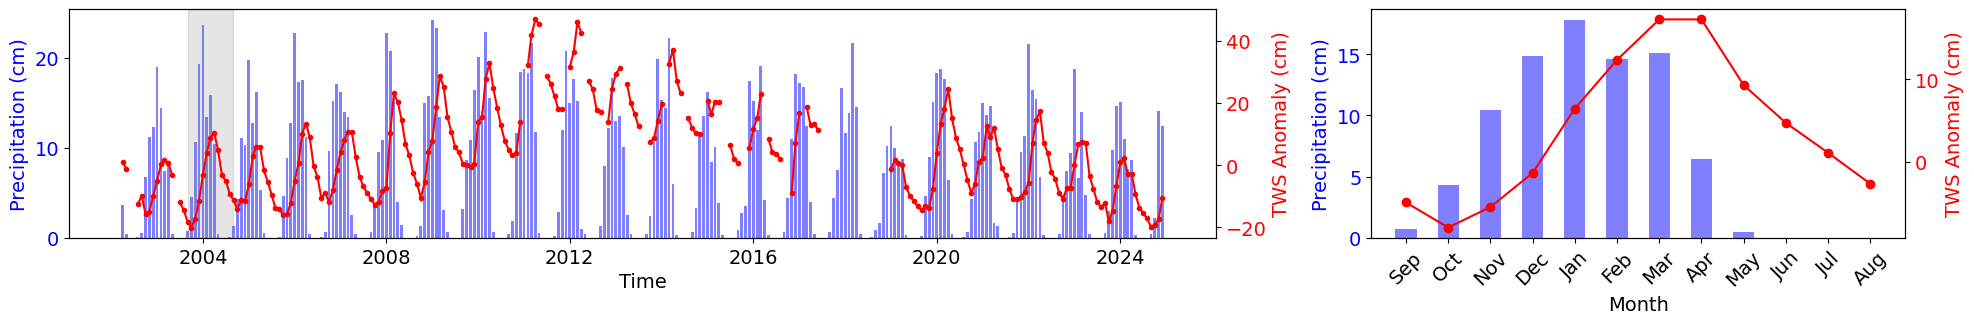

In [15]:
# Subset to 2002–2024 (GRACE period)
start_time = "2002-04-01"
end_time = "2024-12-31"

df = df_combined_monthly.copy() # ensure datetime index already set
tws_subset = df['TWS'].loc[start_time:end_time]
precip_subset = df['Precip'].loc[start_time:end_time]

# Monthly climatologies
tws_clim_df = tws_subset.to_frame(name="TWS")
tws_clim_df["month"] = tws_clim_df.index.month
climatology_tws = tws_clim_df.groupby("month")["TWS"].mean()

precip_clim_df = precip_subset.to_frame(name="Precip")
precip_clim_df["month"] = precip_clim_df.index.month
climatology_precip = precip_clim_df.groupby("month")["Precip"].mean()

# Find month of maximum TWS and Precip, and their values
max_tws_month = climatology_tws.idxmax()
max_tws_value = climatology_tws.max()

max_precip_month = climatology_precip.idxmax()
max_precip_value = climatology_precip.max()

# Print maxima of the climatologies
print(f"Maximum climatological TWS: {max_tws_value:.1f} in month {max_tws_month}")
print(f"Maximum climatological Precip: {max_precip_value:.1f} in month {max_precip_month}")

# Reorder climatologies to water year (Sep–Aug)
month_labels = ["Sep", "Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug"]
water_year_order = [9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8]
climatology_tws = climatology_tws.reindex(water_year_order).reset_index(drop=True)
climatology_precip = climatology_precip.reindex(water_year_order).reset_index(drop=True)

# Plot: time series (left) and water-year climatologies (right)
fig = plt.figure(figsize=(20, 3.5))
gs = gridspec.GridSpec(1, 3, width_ratios=[13, 0, 7])

# Time series panel (Figure 2A)
ax1 = fig.add_subplot(gs[0, 0:2])
# ax1.plot(precip_subset.index, precip_subset.values, linestyle='-', marker='o', markersize=3, color='blue')
ax1.bar(precip_subset.index, precip_subset.values, width=22, color='blue', alpha=0.5, label='Precip')
ax1.set_xlabel("Time")
ax1.set_ylabel("Precipitation (cm)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(tws_subset.index, tws_subset.values, linestyle='-', marker='o', markersize=3, color='red')
ax2.set_ylabel("TWS Anomaly (cm)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Highlight 2003–2004 water year
ax1.axvspan(pd.to_datetime("2003-09-01"), pd.to_datetime("2004-08-31"), color='gray', alpha=0.2)

# Water-year climatology panel (Figure 2B)
ax3 = fig.add_subplot(gs[0, 2])
x_vals = range(1, 13)
# ax3.plot(x_vals, climatology_precip.values, marker="o", linestyle="-", color="blue")
ax3.bar(x_vals, climatology_precip.values, width=0.5, color="blue", alpha=0.5, label='Precip')
ax3.set_xlabel("Month")
ax3.set_ylabel("Precipitation (cm)", color="blue")
ax3.tick_params(axis='y', labelcolor="blue")
ax3.set_xticks(x_vals)
ax3.set_xticklabels(month_labels, rotation=45)

ax4 = ax3.twinx()
ax4.plot(x_vals, climatology_tws.values, marker="o", linestyle="-", color="red")
ax4.set_ylabel("TWS Anomaly (cm)", color="red")
ax4.tick_params(axis='y', labelcolor="red")

plt.tight_layout()
file_suffix = "Figures/Figure2AB.pdf"
if basin_choice == "both":
    plt.savefig(file_suffix, format="pdf", dpi=300, bbox_inches='tight')
plt.show()


### Figure 3: Relationship between inundation extent and climate predictors  
Perform linear regressions between observed Okavango inundation extent and climate variables derived from GRACE and CHIRPS.  
Individual models use annual precipitation, maximum TWS, and March–May mean TWS as predictors, and a combined model includes both precipitation and TWS. Each panel shows the regression fit with corresponding $R^2$ values and 90% bootstrap confidence intervals.


    year  Inundation extent (km2)    tws_max    tws_mam  annual_precipitation
0   2003                     4197   1.670911  -0.329630             80.474260
1   2004                     7744  10.284423   7.932948             99.276514
2   2005                     6668   5.857012   3.284100             81.506874
3   2006                     6957  13.362028  10.781638             95.667008
4   2007                     7969  10.683198   7.991014             89.103104
5   2008                     6859  23.151368  19.319164             88.996782
6   2011                     9658  46.884582  44.665807            103.500059
7   2013                     7216  31.157929  22.880890             78.765885
8   2014                     8090  37.097404  32.275032             91.670318
9   2015                     7504  20.736775  20.305203             68.095310
10  2016                     6885  23.012620  15.716866             75.342177
11  2017                     7483  18.617579  14.809509         

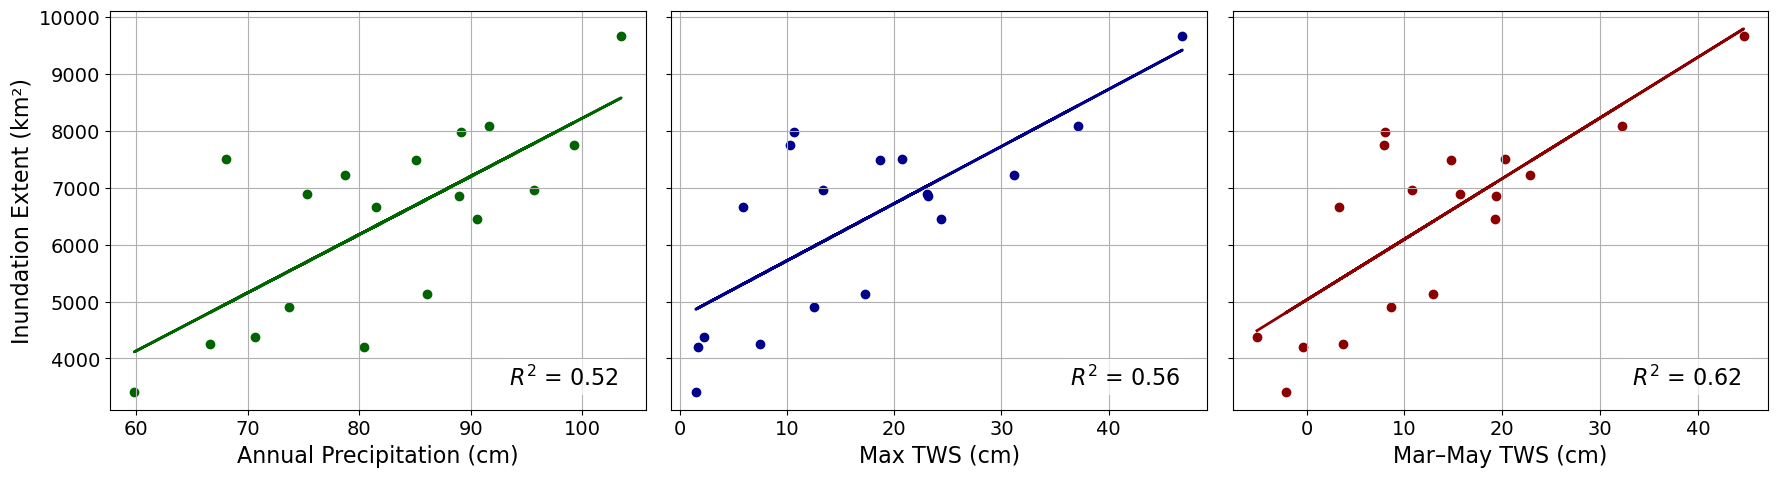

                  Model  n R² (Full) R² Mean        90% CI
   Annual Precipitation 18      0.52    0.52 (0.18 – 0.80)
                Max TWS 18      0.56    0.55 (0.24 – 0.80)
            Mar–May TWS 18      0.62    0.60 (0.32 – 0.83)
Annual Precip + MAM TWS 18      0.73    0.74 (0.52 – 0.89)


In [17]:
# === Regression: Inundation Extent vs Climate Predictors ===

# Prepare TWS metrics
ts_df = df_combined_monthly[["TWS"]].dropna().copy()
ts_df["year"] = ts_df.index.year
ts_df["month"] = ts_df.index.month

max_tws_per_year = ts_df.groupby("year")["TWS"].max().reset_index().rename(columns={"TWS": "tws_max"})
mam_tws_per_year = ts_df[ts_df["month"].isin([3, 4, 5])].groupby("year")["TWS"].mean().reset_index().rename(columns={"TWS": "tws_mam"})

# Prepare annual precipitation (cm)
df_combined_monthly_copy = df_combined_monthly.copy()
df_combined_monthly_copy["year"] = np.where(
    df_combined_monthly_copy.index.month >= 9,
    df_combined_monthly_copy.index.year + 1,
    df_combined_monthly_copy.index.year
)
precip_annual = (
    df_combined_monthly_copy.groupby("year")["Precip"]
    .sum()
    .reset_index()
    .rename(columns={"Precip": "annual_precipitation"})
)

# Load Inundation Dataset
inman_lyons_path = "example_data/OkavangoInundation/Rigden_Inman_Lyons_updated.csv"
df_inman_lyons = pd.read_csv(inman_lyons_path)
df_combined_annual = df_inman_lyons.rename(columns={"Year": "year"})
df_combined_annual = df_combined_annual.merge(max_tws_per_year, on="year", how="inner")
df_combined_annual = df_combined_annual.merge(mam_tws_per_year, on="year", how="inner")
df_combined_annual = df_combined_annual.merge(precip_annual, on="year", how="inner")

# Drop NaNs after aggregation
df_combined_annual = df_combined_annual.dropna(subset=["annual_precipitation", "tws_max", "tws_mam"])

print(df_combined_annual)

# Define models
models = {
    "Annual Precipitation": "annual_precipitation",
    "Max TWS": "tws_max",
    "Mar–May TWS": "tws_mam"
}
colors = {
    "Annual Precipitation": "darkgreen",
    "Max TWS": "darkblue",
    "Mar–May TWS": "darkred"
}

fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
r2_table = []

for i, (label, col) in enumerate(models.items()):

    # Count number of valid data points (non-NaN in both predictor and response)
    n_points = df_combined_annual[[col, "Inundation extent (km2)"]].dropna().shape[0]

    ax = axs[i]
    x = df_combined_annual[[col]].values
    y = df_combined_annual["Inundation extent (km2)"].values

    model = LinearRegression().fit(x, y)
    y_pred = model.predict(x)
    r2 = r2_score(y, y_pred)

    ax.scatter(x, y, color=colors[label])
    ax.plot(x, y_pred, color=colors[label], linewidth=2)
    ax.set_xlabel(f"{label} (cm)", fontsize=16)
    if i == 0:
        ax.set_ylabel("Inundation Extent (km²)", fontsize=16)
    ax.grid(True)
    ax.text(0.95, 0.05, f"$R^2$ = {r2:.2f}", transform=ax.transAxes, ha="right", va="bottom", fontsize=16,
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

    # Bootstrap R²
    r2_vals = []
    for _ in range(10000):
        xb, yb = resample(x, y)
        model_b = LinearRegression().fit(xb, yb)
        yb_pred = model_b.predict(xb)
        r2_vals.append(r2_score(yb, yb_pred))

    r2_table.append({
        "Model": label,
        "n": n_points,
        "R² (Full)": f"{r2:.2f}",
        "R² Mean": f"{np.mean(r2_vals):.2f}",
        "90% CI": f"({np.percentile(r2_vals, 5):.2f} – {np.percentile(r2_vals, 95):.2f})"
    })

# Combined model
# Combined model
valid_idx = df_combined_annual[["annual_precipitation", "tws_mam", "Inundation extent (km2)"]].dropna().index
n_points_combo = len(valid_idx)

X_combo = df_combined_annual[["annual_precipitation", "tws_mam"]].dropna().values
y_combo = df_combined_annual.loc[df_combined_annual[["annual_precipitation", "tws_mam"]].dropna().index, "Inundation extent (km2)"].values

model_combo = LinearRegression().fit(X_combo, y_combo)
y_combo_pred = model_combo.predict(X_combo)
r2_combo = r2_score(y_combo, y_combo_pred)

r2_vals_combo = []
for _ in range(10000):
    Xb, yb = resample(X_combo, y_combo)
    model_b = LinearRegression().fit(Xb, yb)
    yb_pred = model_b.predict(Xb)
    r2_vals_combo.append(r2_score(yb, yb_pred))

r2_table.append({
    "Model": "Annual Precip + MAM TWS",
    "n": n_points_combo,
    "R² (Full)": f"{r2_combo:.2f}",
    "R² Mean": f"{np.mean(r2_vals_combo):.2f}",
    "90% CI": f"({np.percentile(r2_vals_combo, 5):.2f} – {np.percentile(r2_vals_combo, 95):.2f})"
})

# Finalize and save
plt.tight_layout()
file_suffix = "Figures/Figure3.pdf"
if basin_choice == "both":
    plt.savefig(file_suffix, format="pdf", dpi=300)
plt.show()

# Show R² table
r2_df = pd.DataFrame(r2_table)
print(r2_df.to_string(index=False))

### Add mascon IDs to GRACE dataset  
Merge GRACE TWS data with the mascon lookup table to assign each grid cell its corresponding `mascon_ID`.

In [42]:
# Merge GRACE DataFrame with mascon lookup table
tws_mascon_df = pd.merge(
    tws_mascon_df,         # GRACE data with ["time", "lat", "lon", "tws"]
    mascon_df,             # Lookup table with ["lat", "lon", "mascon_ID"]
    on=["lat", "lon"],
    how="inner"
)

print(tws_mascon_df)

             time    lat    lon       tws       date  month  year  \
0      2002-04-01 -20.75  12.75 -1.142446 2002-04-01      4  2002   
1      2002-04-01 -20.75  13.25 -0.473737 2002-04-01      4  2002   
2      2002-04-01 -20.75  13.75 -2.109571 2002-04-01      4  2002   
3      2002-04-01 -20.75  14.25 -2.109571 2002-04-01      4  2002   
4      2002-04-01 -20.75  14.75 -2.109571 2002-04-01      4  2002   
...           ...    ...    ...       ...        ...    ...   ...   
128145 2024-12-01 -10.25  22.75  2.498924 2024-12-01     12  2024   
128146 2024-12-01 -10.25  23.25  2.498924 2024-12-01     12  2024   
128147 2024-12-01 -10.25  23.75  2.498924 2024-12-01     12  2024   
128148 2024-12-01 -10.25  24.25  2.498924 2024-12-01     12  2024   
128149 2024-12-01 -10.25  24.75  9.434687 2024-12-01     12  2024   

        mascon_ID_x  mascon_ID_y  
0            3041.0       3041.0  
1            3042.0       3042.0  
2            3042.0       3042.0  
3            3042.0       3042.

### Correlation analysis: Inundation extent vs. climate drivers  
Compute mascon-level correlations between annual inundation extent and two climate predictors — total water-year precipitation and March–May mean GRACE TWS.  
A bootstrap procedure (10,000 iterations) estimates Pearson correlation means and 90% confidence intervals, identifying robust relationships across mascons.

In [21]:
# Parameters
num_boot = 10000
ci_bounds = (5, 95)

# Bootstrap Function
def bootstrap_pearsonr(x, y, n_bootstrap=num_boot, ci=ci_bounds):
    corrs = []
    for _ in range(n_bootstrap):
        x_res, y_res = resample(x, y)
        if x_res.std() > 0 and y_res.std() > 0:
            r, _ = pearsonr(x_res, y_res)
            corrs.append(r)
    if len(corrs) > 0:
        lower = np.percentile(corrs, ci[0])
        upper = np.percentile(corrs, ci[1])
        return np.mean(corrs), lower, upper
    else:
        return np.nan, np.nan, np.nan

# Assign Water Year (Sep–Aug) for Precip
precip_mascon_df["date"] = pd.to_datetime(precip_mascon_df["time"])
precip_mascon_df["month"] = precip_mascon_df["date"].dt.month
precip_mascon_df["water_year"] = precip_mascon_df["date"].dt.year
precip_mascon_df.loc[precip_mascon_df["month"] >= 9, "water_year"] += 1

# Sum Precipitation Over Water Year
precip_annual = (
    precip_mascon_df
    .groupby(["water_year", "mascon_ID"])["precip"]
    .sum()
    .reset_index()
    .rename(columns={"water_year": "year"})
)

# Average GRACE Over MAM
tws_mascon_df["date"] = pd.to_datetime(tws_mascon_df["time"])
tws_mascon_df["month"] = tws_mascon_df["date"].dt.month
tws_mascon_df["year"] = tws_mascon_df["date"].dt.year
tws_mam = (
    tws_mascon_df[tws_mascon_df["month"].isin([3, 4, 5])]
    .groupby(["year", "mascon_ID"])["tws"]
    .mean()
    .reset_index()
)

# Prepare Inundation Data
df_inundation = df_combined_annual[["year", "Inundation extent (km2)"]].dropna()

# Correlation By Mascon
all_ids = sorted(set(precip_annual["mascon_ID"]) & set(tws_mam["mascon_ID"]))
corr_list = []

for i, mascon_id in enumerate(all_ids, 1):
    print(f"Processing mascon {i} of {len(all_ids)}")

    # Merge across all datasets
    df = (
        pd.merge(precip_annual[precip_annual["mascon_ID"] == mascon_id], tws_mam[tws_mam["mascon_ID"] == mascon_id], on="year", suffixes=("_precip", "_tws"))
        .merge(df_inundation, on="year")
        .dropna()
    )

    if len(df) >= 5:
        x = df["precip"].values
        y = df["Inundation extent (km2)"].values
        r_p_mean, r_p_lo, r_p_hi = bootstrap_pearsonr(x, y)

        x = df["tws"].values
        r_t_mean, r_t_lo, r_t_hi = bootstrap_pearsonr(x, y)

        corr_list.append({
            "mascon_ID": mascon_id,
            "precip_corr": r_p_mean,
            "precip_lo": r_p_lo,
            "precip_hi": r_p_hi,
            "grace_corr": r_t_mean,
            "grace_lo": r_t_lo,
            "grace_hi": r_t_hi,
        })

corr_df = pd.DataFrame(corr_list)

# Merge Correlation Back To Grid Cells
grid_info = precip_mascon_df.drop_duplicates(subset=["mascon_ID", "lat", "lon"])[["mascon_ID", "lat", "lon"]]
corr_df_expanded = pd.merge(grid_info, corr_df, on="mascon_ID", how="inner")

# Optional: Robust Threshold Flags
corr_df_expanded["precip_robust"] = (corr_df_expanded["precip_corr"] > 0.5) & (corr_df_expanded["precip_lo"] > 0)
corr_df_expanded["grace_robust"] = (corr_df_expanded["grace_corr"] > 0.5) & (corr_df_expanded["grace_lo"] > 0)

print(corr_df_expanded.head())

Processing mascon 1 of 23
Processing mascon 2 of 23
Processing mascon 3 of 23
Processing mascon 4 of 23
Processing mascon 5 of 23
Processing mascon 6 of 23
Processing mascon 7 of 23
Processing mascon 8 of 23
Processing mascon 9 of 23
Processing mascon 10 of 23
Processing mascon 11 of 23
Processing mascon 12 of 23
Processing mascon 13 of 23
Processing mascon 14 of 23
Processing mascon 15 of 23
Processing mascon 16 of 23
Processing mascon 17 of 23
Processing mascon 18 of 23
Processing mascon 19 of 23
Processing mascon 20 of 23
Processing mascon 21 of 23
Processing mascon 22 of 23
Processing mascon 23 of 23
   mascon_ID    lat    lon  precip_corr  precip_lo  precip_hi  grace_corr  \
0     3041.0 -20.75  12.75     0.464924   0.136261   0.733263   -0.350733   
1     3042.0 -20.75  13.25     0.540282   0.203124   0.776444    0.213604   
2     3042.0 -20.75  13.75     0.540282   0.203124   0.776444    0.213604   
3     3042.0 -20.75  14.25     0.540282   0.203124   0.776444    0.213604   
4  

### Figure 4: Spatial correlations between inundation extent and climate predictors  
Map the mascon-level Pearson correlations between annual inundation extent and (left) precipitation and (right) GRACE TWS.  
Black dots mark robust correlations (mean > 0.5 and lower 90% CI > 0), with basin boundaries and the Angolan Highlands Water Tower outlined for reference.

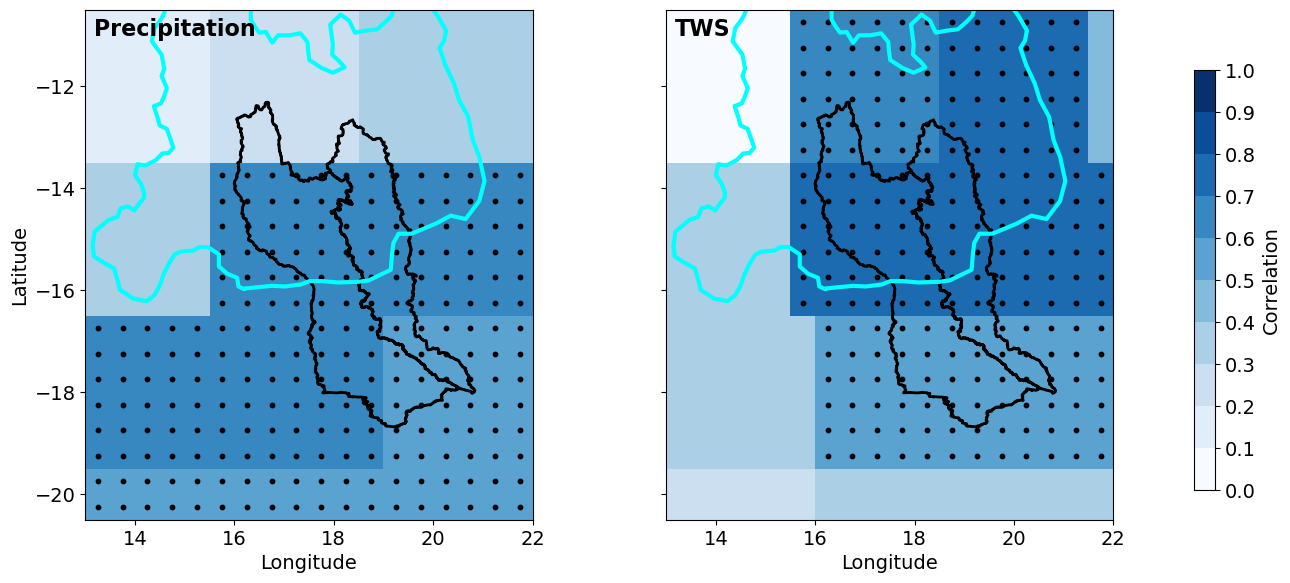

In [44]:
# Grid Setup
res = 0.5  # grid resolution

lon_centers = np.sort(corr_df_expanded["lon"].unique())
lat_centers = np.sort(corr_df_expanded["lat"].unique())

# Define grid edges for pcolormesh
lon_edges = np.append(lon_centers - res / 2, lon_centers[-1] + res / 2)
lat_edges = np.append(lat_centers - res / 2, lat_centers[-1] + res / 2)
lon_grid, lat_grid = np.meshgrid(lon_edges, lat_edges)

# Pivot data for plotting
grid_precip = corr_df_expanded.pivot(index="lat", columns="lon", values="precip_corr").values
grid_grace = corr_df_expanded.pivot(index="lat", columns="lon", values="grace_corr").values

# Define discrete colormap and norm
cmap_corr = "Blues"
bounds = np.arange(0, 1.01, 0.1)  # from 0 to 1 by 0.1
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=plt.get_cmap(cmap_corr).N)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Precip correlation
mesh1 = axs[0].pcolormesh(lon_grid, lat_grid, grid_precip, cmap=cmap_corr, norm=norm, shading='auto')
axs[0].scatter(corr_df_expanded.loc[corr_df_expanded["precip_robust"], "lon"],
               corr_df_expanded.loc[corr_df_expanded["precip_robust"], "lat"],
               color='black', marker='.', s=40, linewidths=1)
axs[0].set_xlabel("Longitude")
axs[0].set_ylabel("Latitude")

# GRACE correlation
mesh2 = axs[1].pcolormesh(lon_grid, lat_grid, grid_grace, cmap=cmap_corr, norm=norm, shading='auto')
axs[1].scatter(corr_df_expanded.loc[corr_df_expanded["grace_robust"], "lon"],
               corr_df_expanded.loc[corr_df_expanded["grace_robust"], "lat"],
               color='black', marker='.', s=40, linewidths=1)
axs[1].set_xlabel("Longitude")

# Overlay shapefiles
ahwt = gpd.read_file("example_data/Angolan_Highlands_Water_Tower_area/Angolan_Highlands_Water_Tower_area.shp").to_crs("EPSG:4326")
for ax in axs:
    basins.boundary.plot(ax=ax, color="black", linewidth=2)
    ahwt.boundary.plot(ax=ax, edgecolor='cyan', linewidth=3)

# Shared discrete colorbar
cbar_ax = fig.add_axes([0.90, 0.15, 0.015, 0.7])
cbar = fig.colorbar(mesh2, cax=cbar_ax, ticks=bounds, spacing='uniform')
cbar.set_label("Correlation")

# Format and save
axs[0].text(0.02, 0.95, "Precipitation", transform=axs[0].transAxes, fontsize=16, weight='bold')
axs[1].text(0.02, 0.95, "TWS", transform=axs[1].transAxes, fontsize=16, weight='bold')
axs[0].set_ylim(bottom=-20.5, top=-10.5)
axs[0].set_xlim(left=13, right=22)

plt.subplots_adjust(left=0.07, right=0.88, wspace=0.05, top=0.95, bottom=0.1)
if basin_choice == "both":
    plt.savefig("Figures/Figure4.pdf", format="pdf", dpi=300)
plt.show()

### Compute mean annual amplitude of GRACE TWS and CHIRPS precipitation  
Calculate annual amplitude (max–min) for each year and grid cell, then average across all years (excluding 2018) to obtain mean seasonal variability.  
The resulting `mean_amp_grace` and `mean_amp_precip` DataFrames represent spatial patterns of hydrologic seasonality across the Okavango region.


In [45]:
# GRACE vs Precip: Mean Annual Amplitude Maps (Mascon-Averaged)

# Filter TWS DataFrame (exclude 2018)
tws_df_amp = tws_mascon_df.copy()
tws_df_amp["year"] = pd.to_datetime(tws_df_amp["time"]).dt.year
tws_df_amp = tws_df_amp[tws_df_amp["year"] != 2018]
tws_df_amp = tws_df_amp[
    (tws_df_amp["lat"] >= -20.5) & (tws_df_amp["lat"] <= -10) &
    (tws_df_amp["lon"] >= 12.5) & (tws_df_amp["lon"] <= 22.5)
]

print(tws_df_amp)

# Compute annual amplitude (max - min) per year
amplitude_grace = (
    tws_df_amp.groupby(["lat", "lon", "year"])["tws"]
    .agg(lambda x: x.max() - x.min())
    .reset_index(name="amplitude")
)

# Compute multi-year mean
mean_amp_grace = amplitude_grace.groupby(["lat", "lon"])["amplitude"].mean().reset_index()

# --- Precip ---
precip_df_amp = precip_mascon_df.copy()
precip_df_amp["year"] = pd.to_datetime(precip_df_amp["time"]).dt.year
precip_df_amp = precip_df_amp[
    (precip_df_amp["lat"] >= -20.5) & (precip_df_amp["lat"] <= -10) &
    (precip_df_amp["lon"] >= 12.5) & (precip_df_amp["lon"] <= 22.5)
]

print(precip_df_amp)

# Compute annual amplitude
amplitude_precip = (
    precip_df_amp.groupby(["lat", "lon", "year"])["precip"]
    .agg(lambda x: x.max() - x.min())
    .reset_index(name="amplitude")
)
amplitude_precip["amplitude"]

# Multi-year mean
mean_amp_precip = amplitude_precip.groupby(["lat", "lon"])["amplitude"].mean().reset_index()

             time    lat    lon        tws       date  month  year  \
25     2002-04-01 -20.25  12.75  -1.142446 2002-04-01      4  2002   
26     2002-04-01 -20.25  13.25  -2.109571 2002-04-01      4  2002   
27     2002-04-01 -20.25  13.75  -2.109571 2002-04-01      4  2002   
28     2002-04-01 -20.25  14.25  -2.109571 2002-04-01      4  2002   
29     2002-04-01 -20.25  14.75  -2.109571 2002-04-01      4  2002   
...           ...    ...    ...        ...        ...    ...   ...   
128140 2024-12-01 -10.25  20.25  11.707637 2024-12-01     12  2024   
128141 2024-12-01 -10.25  20.75  11.707637 2024-12-01     12  2024   
128142 2024-12-01 -10.25  21.25  11.707637 2024-12-01     12  2024   
128143 2024-12-01 -10.25  21.75   2.498924 2024-12-01     12  2024   
128144 2024-12-01 -10.25  22.25   2.498924 2024-12-01     12  2024   

        mascon_ID_x  mascon_ID_y  
25           3041.0       3041.0  
26           3042.0       3042.0  
27           3042.0       3042.0  
28           3042.0

### Figure 5: Mean annual amplitude of GRACE TWS and precipitation  
Display the spatial patterns of mean annual amplitude (seasonal range) for CHIRPS precipitation and GRACE TWS across the Angolan Highlands.  
Both panels share a consistent 0–40 cm color scale, with basin boundaries in black and the Angolan Highlands Water Tower outlined in cyan.


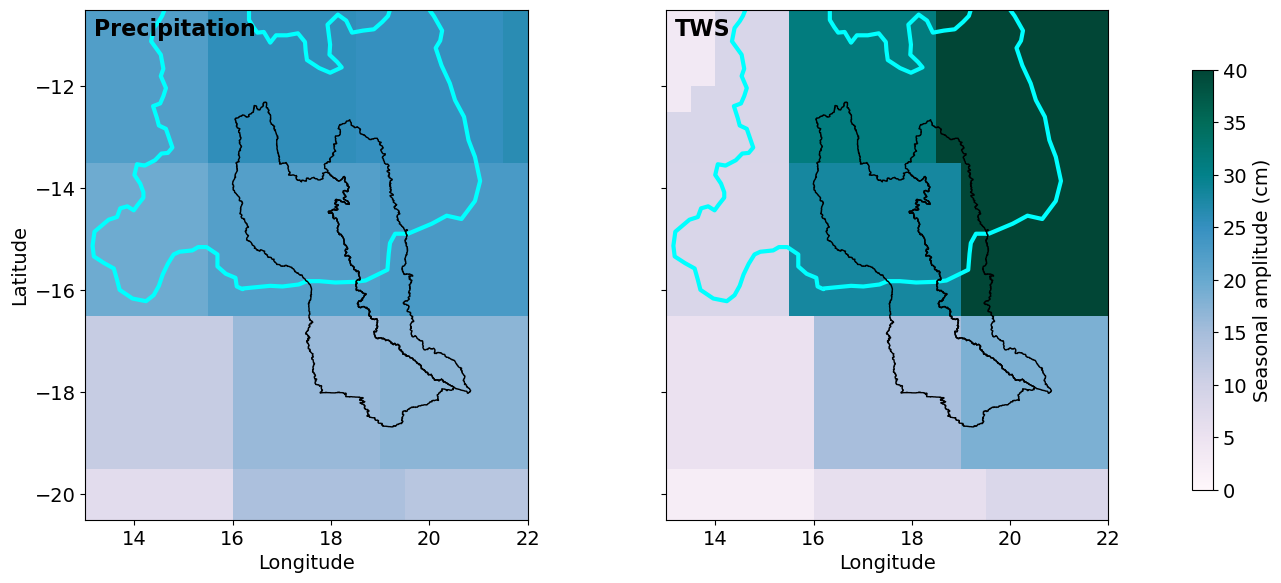

In [39]:
# Plot: Mean Annual Amplitude of Precip and GRACE (Mascon-Based)

# Define grid resolution (assuming 0.5°)
res = 0.5
lon_centers = np.sort(mean_amp_grace["lon"].unique())
lat_centers = np.sort(mean_amp_grace["lat"].unique())

# Define grid edges
lon_edges = np.concatenate(([lon_centers[0] - res / 2],
                            lon_centers[:-1] + res / 2,
                            [lon_centers[-1] + res / 2]))
lat_edges = np.concatenate(([lat_centers[0] - res / 2],
                            lat_centers[:-1] + res / 2,
                            [lat_centers[-1] + res / 2]))

lon_grid, lat_grid = np.meshgrid(lon_edges, lat_edges)

# Grid values
grid_precip = mean_amp_precip.pivot(index="lat", columns="lon", values="amplitude").values
grid_grace = mean_amp_grace.pivot(index="lat", columns="lon", values="amplitude").values

# Create figure
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
cmap_amp = "PuBuGn"

# Precipitation panel
mesh1 = axs[0].pcolormesh(lon_grid, lat_grid, grid_precip,
                          cmap=cmap_amp, vmin=0, vmax=40, shading='auto')
mesh1.set_rasterized(True)
axs[0].set_xlabel("Longitude")
axs[0].set_ylabel("Latitude")
axs[0].text(0.02, 0.95, "Precipitation", transform=axs[0].transAxes, fontsize=16, weight='bold')

# GRACE panel
mesh2 = axs[1].pcolormesh(lon_grid, lat_grid, grid_grace,
                          cmap=cmap_amp, vmin=0, vmax=40, shading='auto')
mesh2.set_rasterized(True)
axs[1].set_xlabel("Longitude")
axs[1].text(0.02, 0.95, "TWS", transform=axs[1].transAxes, fontsize=16, weight='bold')

# Load and overlay AHWT
ahwt = gpd.read_file("example_data/Angolan_Highlands_Water_Tower_area/Angolan_Highlands_Water_Tower_area.shp")
ahwt = ahwt.to_crs("EPSG:4326")
for ax in axs:
    ahwt.boundary.plot(ax=ax, edgecolor='cyan', linewidth=3)

# Overlay basins
for ax in axs:
    basins.boundary.plot(ax=ax, color="black", linewidth=1)

# Axes limits
for ax in axs:
    ax.set_xlim(13, 22)
    ax.set_ylim(-20.5, -10.5)

# Shared colorbar
cbar_ax = fig.add_axes([0.90, 0.15, 0.015, 0.7])
fig.colorbar(mesh2, cax=cbar_ax, label="Seasonal amplitude (cm)")

# Layout
plt.subplots_adjust(left=0.07, right=0.88, wspace=0.05, top=0.95, bottom=0.1)

# Save and show
if basin_choice == "both":
    plt.savefig("Figures/Figure5.pdf", format="pdf", dpi=300)
plt.show()
